# Jupyterthon
## Incident Response - Firewall log analysis
https://github.com/lucky-luk3/Infosec_Notebooks/raw/main/Jupyterthon-Firewall_Log_Analysis.rar  
This book is created for the analysis of firewall log files.
This book helps in the different phases of the investigation:
* [Parse of logs](#parsing)
* [Sanitization of log files](#sanitization)
* [Column filtering](#column_filter)
* [Filtering results](#result_filter)
* [Log analysis](#analysis):
    * Crossing of logs with IOCs
    * IP address behavior analysis
* [PCA reduction](#pca)

### <a name="parsing"></a> 1 - Log transformation
Fortinet log files are in the format "key=value". This section performs a registry conversion to csv extraction keys and values of each item on each record line.  
New analyzers can be easily added by adding new analysis functions.  
You can skyp this section when your log files are already in csv format.  
**Execute all cells in this notebook**

In [1]:
def write_file_functions(file_folder, output_path=""):
    import os
    """
    Create file in current folder with necessary functions.
    :param file_folder: String: Logs file folder path.
    :param output_path: String: Destination csv files path.
    :return: Bool: If process doesn't raise any error.
    """
    try:
        import codecs
        f = codecs.open(os.path.join(file_folder, "process_file.py"), "w+", "utf-8")

        file_content = f"""def load_log(log_string_list):
    import re
    import pandas as pd
    
    def change_unicode(str_line):
        import unidecode
        unicode_string = unidecode.unidecode(str(str_line))
        return unicode_string

    pattern = re.compile('(\w+)=(?:"([^"]*)"|(\S*))')

    lines_s = pd.Series(log_string_list)
    lines_s = lines_s.apply(change_unicode)
    data = lines_s.str.extractall(pattern)
    data.index = data.index.get_level_values(0)
    data[1] = data[1].fillna(data[2])
    return data.pivot(index=None, columns=0, values=1)
        
        
def process_file(file):
    import pandas as pd
    from os import path

    output_folder = r'{output_path}'
    first = True
    with open(file, "r", encoding="latin-1" ) as f:
        if first:
            log_df = load_log(f.readlines())
            first = False
        else:
            t_df = load_log(f.readlines())
            log_df = log_df.append(t_df)
            del t_df
    file_name = path.basename(file)
    file_path =path.join(output_folder, file_name + '.csv')
    log_df.to_csv(file_path)

    del log_df"""

        f.write(file_content)
        f.close()

        return True
    except:
        print("Unexpected error:", sys.exc_info()[0])
        raise
        return False

In [2]:
def process_forti_key_value(logs_folder=""):
    """
    Process Fortinet log files to create csv files using parallelization with the half available cores less one.
    :param logs_folder: String: Logs folder path
    :return: Bool: If files where processed
    """
    from multiprocessing import Pool, cpu_count
    import process_file

    if '__main__' == '__main__':
        try:
            n_cores = int(cpu_count()/2-1)
            num_processors = n_cores
            p = Pool(processes=num_processors)
            logs_folder = logs_folder

            files = read_files_folder(logs_folder, "")

            p.map(process_file.process_file, files)

            p.close()
            p.join()

            return True
        except:
            import sys
            print("Unexpected error:", sys.exc_info()[0])
            raise
            return False
        
def delete_file_functions(file_folder):
    # Delete temporal file created to perform multiprocessing
    import os
    os.remove(os.path.join(file_folder,"process_file.py"))

def read_files_folder(path, extension=""):
    """
    Read files in provided folder with certain extension and return full path of files.
    :param path: String: Folder path to search in.
    :param extension: String: Extension by which the files have to end.
    :return files: List: List of files.
    """
    import glob
    import os
    files = glob.glob(os.path.join(path,f"*.*{extension}"))
    return files

In [3]:
def are_logs_sanitized(csv_logs_folder):
    """
    Checks if logs in folder have the same columns,
    :param csv_logs_folder: String: Logs folder Path.
    :return: Bool: If all files have the same columns.
    """
    import d6tstack.combine_csv

    files = read_files_folder(csv_logs_folder, "csv")
    c = d6tstack.combine_csv.CombinerCSV(files)

    return c.is_all_equal()

In [4]:
def logs_start_menu(click_function = None):
    from ipyfilechooser import FileChooser
    import ipywidgets as widgets
    from IPython.display import display, Markdown, clear_output
    from time import time
    import datetime

    logs = {"Fortinet":["key-value"]}

    output = widgets.Output()

    def print_process_type(process_type):
        if "key-value" in log_format.value:
            button.description = "Parse logs to CSV"

    def select_log_type(log_type):
        log_format.options = logs[log_type]

    log_type = widgets.Dropdown(
        options=list(logs.keys()),
        description='Log type:',
        disabled=False,
        )
    init = log_type.value
    log_format = widgets.Dropdown(
        options=logs[init],
        description='Format:',
        disabled=False,
    )
    button = widgets.Button(description=f'Analyze {init}')

    j = widgets.interactive(print_process_type, process_type=log_format)
    i = widgets.interactive(select_log_type, log_type=log_type)

    display(Markdown('### Log conversion menu'))
    display(Markdown('Select a log folder to convert.'))
    fc = FileChooser()
    fc.show_only_dirs = True
    fc.show_hidden = True
    fc.use_dir_icons = True
    fc.title = '<b>Input folder Path</b>'

    fc_out = FileChooser()
    fc_out.show_only_dirs = True
    fc_out.show_hidden = True
    fc_out.use_dir_icons = True
    fc_out.title = '<b>Output folder Path</b>'
    display(fc, i, j, fc_out, button, output)
    def _click_function(_):
        with output:
            clear_output()
            if fc.selected:
                f_name_input = fc.selected
                f_name_input = f_name_input.replace('\\', '\\\\')
                try:
                    if "key-value" in log_format.value:
                        if fc_out.selected:
                            start_time = time()
                            f_name_out = fc_out.selected
                            f_name_out = f_name_out.replace('\\', '\\\\')
                            import os
                            cwd = os.getcwd()
                            result = write_file_functions(cwd, f_name_out)
                            if not result:
                                display(Markdown(f'**Error** writing file'))
                            display(Markdown(f'Processing files please **wait**'))
                            finish = process_forti_key_value(f_name_input)
                            delete_file_functions(cwd)
                            elapsed_time = time() - start_time
                            elapsed_time = str(datetime.timedelta(seconds=elapsed_time))
                            if finish:
                                display(Markdown(f'Elapsed time: {elapsed_time}.'))
                                display(Markdown(f'Logs processed in folder: {f_name_out}'))
                                valid = widgets.Valid(value=True, description='Processed')
                                display(valid)
                                if not are_logs_sanitized(f_name_out):
                                    display(Markdown(f'## **Logs not Sanitized!**'))
                                    display(Markdown(f'Use: `sanitize_log_menu`'))
                            else:
                                display(Markdown(f'**ERROR** processing files: {f_name_out}'))
                        else:
                            display(Markdown(f'Please insert an output folder.'))
                except KeyError:
                    display(Markdown('**Unable to analyze logs.**'))
                    invalid = widgets.Valid(value=False, description='Processed')
                    display(invalid)
            else:
                display(Markdown(f'Please select a **log folder**'))

    if click_function:
        button.on_click(click_function)
    else:
        button.on_click(_click_function)

In [5]:
logs_start_menu()

ModuleNotFoundError: No module named 'ipyfilechooser'

### <a name="sanitization"></a> 2 - Log files sanitization  
It's common when you are working with key-value log files that the result files have different number of columns.  
This sections create a new version of all logs files with same columns.

In [6]:
def sanitize_logs(csv_logs_folder, output_dir):
    """
    Read files in folder and create new file version with same columns in all files.
    :param csv_logs_folder: String: CSV logs folder path.
    :param output_dir: String: Sanitized destination folder path.
    :return: Bool: If sanitization was correct.
    """
    import d6tstack.combine_csv

    files = read_files_folder(csv_logs_folder, "csv")
    c = d6tstack.combine_csv.CombinerCSV(files)
    if not c.is_all_equal():
        try:
            fnames = d6tstack.combine_csv.CombinerCSV(files).to_csv_align(output_dir=output_dir)
            return True
        except:
            import sys
            print("Unexpected error:", sys.exc_info()[0])
            raise
    else:
        return False

In [7]:
def sanitize_log_menu(click_function = None):
    from ipyfilechooser import FileChooser
    import ipywidgets as widgets
    from IPython.display import display, Markdown, clear_output

    output = widgets.Output()
    display(Markdown('### Sanitized logs menu'))
    fc = FileChooser()
    fc.show_only_dirs = True
    fc.show_hidden = True
    fc.use_dir_icons = True
    fc.title = '<b>Input folder Path</b>'

    fc_out = FileChooser()
    fc_out.show_only_dirs = True
    fc_out.show_hidden = True
    fc_out.use_dir_icons = True
    fc_out.title = '<b>Output folder Path</b>'

    button = widgets.Button(description=f'Sanitize logs')

    display(fc, fc_out, button, output)

    def _click_function(_):
        with output:
            if fc.selected and fc_out.selected:
                from time import time
                import datetime
                start_time = time()
                f_name_input = fc.selected
                f_name_input = f_name_input.replace('\\', '\\\\')
                f_name_out = fc_out.selected
                f_name_out = f_name_out.replace('\\', '\\\\')

                result = sanitize_logs(f_name_input, f_name_out)
                elapsed_time = time() - start_time
                elapsed_time = str(datetime.timedelta(seconds=elapsed_time))
                if result:
                    clear_output()
                    display(Markdown(f'Elapsed time: {elapsed_time}.'))
                    display(Markdown(f'Logs Sanitized in folder {f_name_out}'))
                else:
                    display(Markdown(f'These logs do **not need to be sanitized**.'))
            else:
                display(Markdown('**Please select input and output folder**'))


    if click_function:
        button.on_click(click_function)
    else:
        button.on_click(_click_function)


In [8]:
sanitize_log_menu()

### Sanitized logs menu

FileChooser(path='E:\93-Notebooks', filename='', title='HTML(value='<b>Input folder Path</b>')', show_hidden='…

FileChooser(path='E:\93-Notebooks', filename='', title='HTML(value='<b>Output folder Path</b>')', show_hidden=…

Button(description='Sanitize logs', style=ButtonStyle())

Output()

### <a name="column_filter"></a> 3 - Columns selection  
In this section you can choose which column you are interested in.  
Since the code is prepared for all types of logs, it is necessary to select the columns indicating what their types are.

In [9]:
def get_logs_columns(logs_folder):
    """
    Return columns in csv files in provided folder.
    :param logs_folder: String: Logs folder path
    :return solumns: List: List of columns in files.
    """
    import glob
    import pandas as pd
    import d6tstack.combine_csv

    cfg_fnames = list(glob.glob(f"{logs_folder}*.*"))
    c = d6tstack.combine_csv.CombinerCSV(cfg_fnames)
    columns = c.preview_select()

    return columns

def process_logs_disk(logs_folder, str_columns, int_columns, date_columns):
    """
    Create a Pandas DataFrame with files in provided folder and columns.
    :param logs_folder: String: Logs folder path
    :param columns: List: Desired columns
    :return data: DataFrame: Dask DataFrame with logs
    """
    import dask.dataframe as dd

    dtype = {}

    columns = str_columns + int_columns + date_columns
    for col in columns:
        dtype[col] = object

    df_dask = dd.read_csv(logs_folder + "*.*", dtype=dtype, usecols=columns, encoding="latin-1")

    for col in str_columns:
        df_dask[col] = df_dask[col].astype(object)
    for col in date_columns:
        df_dask[col] = dd.to_datetime(df_dask[col])
    for col in int_columns:
        df_dask[col] = dd.to_numeric(df_dask[col])

    return df_dask

In [10]:
def log_columns_menu(click_function = None):
    """
    :param click_function:
    :return:
    Menu when you have a sanitize csv logs.
    """
    from ipyfilechooser import FileChooser
    import ipywidgets as widgets
    from IPython.display import display, Markdown, clear_output

    output = widgets.Output()
    display(Markdown('### Selection columns menu.'))
    fc = FileChooser()
    fc.show_only_dirs = True
    fc.show_hidden = True
    fc.use_dir_icons = True
    fc.title = '<b>Logs folder Path</b>'
    button_analyze = widgets.Button(description=f'Analyze logs')
    display(fc, button_analyze, output)

    def _click_function(_):
        with output:
            if fc.selected:
                f_name_input = fc.selected
                f_name_input = f_name_input.replace('\\', '\\\\')
                clear_output()
                fc.close()
                button_analyze.close()
                columns = get_logs_columns(f_name_input)

                def disk_columns_click(_):
                    from time import time
                    import datetime
                    start_time = time()
                    with output:
                        grid.close()
                        button_columns.close()
                        display(Markdown(f'### Analyzing logs from disk, please **wait**.'))
                        from picatrix.lib import utils
                        utils.ipython_bind_global('f_name_input', f_name_input)
                        str_columns = list(str_select.value)
                        int_columns = list(int_select.value)
                        date_columns = list(date_select.value)
                        df = process_logs_disk(f_name_input, str_columns, int_columns, date_columns)
                        elapsed_time = time() - start_time
                        elapsed_time = str(datetime.timedelta(seconds=elapsed_time))
                        utils.ipython_bind_global('df_result', df)
                        display(Markdown(f'Elapsed time: {elapsed_time}.'))
                        #display(Markdown(f'Results length: {len(df)}.'))
                        display(Markdown(f'Results are stored in the **df_result**.'))
                        display(Markdown(f'Log folder are stored in the **f_name_input**.'))

                from ipywidgets import GridspecLayout
                grid = GridspecLayout(1, 3)
                str_select = widgets.SelectMultiple(
                    description='String:',
                    disabled=False,
                    options=columns,
                    layout={'height': '300px', 'width': '80%'})
                int_select = widgets.SelectMultiple(
                    description='Number:',
                    #value=['duration', 'rcvdbyte', 'sentbyte'],
                    disabled=False,
                    options=columns,
                    layout={'height': '300px', 'width': '80%'})
                date_select = widgets.SelectMultiple(
                    description='Date:',
                    disabled=False,
                    options=columns,
                    layout={'height': '300px', 'width': '80%'})
                grid[0, 0] = str_select
                grid[0, 1] = int_select
                grid[0, 2] = date_select
                button_columns = widgets.Button(description=f'Analyze')
                button_columns.on_click(disk_columns_click)
                clear_output()

                display(grid,button_columns)
            else:
                display(Markdown('**Please select input folder**'))
    if click_function:
        button_analyze.on_click(click_function)
    else:
        button_analyze.on_click(_click_function)

In [17]:
log_columns_menu()

### Selection columns menu.

FileChooser(path='E:\93-Notebooks', filename='', title='HTML(value='<b>Logs folder Path</b>')', show_hidden='T…

Button(description='Analyze logs', style=ButtonStyle())

Output()

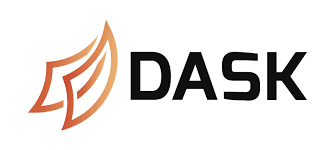  
https://dask.org/

In [18]:
df_result.dtypes

action                object
date          datetime64[ns]
dstcountry            object
dstip                 object
duration               int64
rcvdbyte               int64
rcvdpkt                int64
sentbyte               int64
sentpkt                int64
service               object
srccountry            object
srcip                 object
time                  object
dtype: object

In [13]:
type(df_result)

dask.dataframe.core.DataFrame

In [14]:
%%time
df_result.head()

Wall time: 1.4 s


,action,date,dstcountry,dstip,duration,rcvdbyte,rcvdpkt,sentbyte,sentpkt,srccountry,srcip,time
0,close,2021-11-06,United States,103.61.111.133,1.0,1899.0,9.0,1111.0,8.0,Reserved,10.14.141.55,08:14:13
1,server-rst,2021-11-06,Australia,40.100.54.148,5.0,131.0,3.0,60.0,1.0,Reserved,10.14.141.103,08:14:13
2,server-rst,2021-11-06,Australia,40.100.54.148,5.0,131.0,3.0,60.0,1.0,Reserved,10.14.141.103,08:14:13
3,client-rst,2021-11-06,Australia,103.131.91.88,10.0,1046.0,NaN,1923.0,15.0,Netherlands,194.61.55.45,08:14:13
4,client-rst,2021-11-06,Australia,103.131.91.88,8.0,1006.0,NaN,1858.0,10.0,Netherlands,88.151.85.54,08:14:13


In [17]:
%%time
len(df_result)

Wall time: 2.57 s


400000

### <a name="result_filter"></a> 4 - Data filtering  
In this section it is possible to filter the data using the summary information for each column.  
Each column will be summarized and you can select the results you want to exclude.

In [19]:
def filter_log_menu(click_function = None):
    import ipywidgets as widgets
    from IPython.display import display, Markdown, clear_output
    from pandas.api.types import is_string_dtype
    from picatrix.lib import utils
    from ipywidgets import GridspecLayout

    df = utils.ipython_get_global('df_result')
    columns = df.columns

    output_filter = widgets.Output()

    filter_cols = widgets.SelectMultiple(
        description=f'Columns:',
        disabled=False,
        options=columns,
        layout={'height': '200px', 'width': '80%'})


    def filter_columns(_):
        with output_filter:
            display(Markdown(f'Resuming your data please **wait**.'))
            widgets_list = []
            # Iterate columns in dataframe
            for col in df[list(filter_cols.value)]:
                # Check if column is a string type column
                if is_string_dtype(df[col]):
                    # Extract largest unique values in column
                    col_s = df[col].value_counts().nlargest(20).compute()
                    string_cols = []
                    # Iterate and format every result
                    for e in col_s.to_dict():
                        string_cols.append(f"{e} \t {str(col_s.to_dict()[e])}")
                    # Creates a multi-selection widget and create a list with them
                    widgets_list.append(widgets.SelectMultiple(
                        description=f'{col}:',
                        disabled=False,
                        options=string_cols,
                        layout={'height': '200px', 'width': '80%'}))

            def filter_data(_):
                with output_filter:
                    grid.close()
                    button_filter.close()
                    clear_output()
                    # Get widgets values
                    query_vals = {}
                    for w in widgets_list:
                        query_vals[w.description.split(":")[0]] = [i.split()[0] for i in w.value]

                    # Creates a filter query 
                    query = ' & '.join([f'`{k}` not in {v}' for k, v in query_vals.items()])

                    df_filtered = df.query(query)

                    from picatrix.lib import utils
                    utils.ipython_bind_global('df_result', df_filtered)
                    display(Markdown(f'Filtered results are stored in the **df_result**.'))


            # Creates a grid with widgets
            row = 0
            col = 0
            n_rows = len(widgets_list) // 3 + 1
            if len(widgets_list) % 3 == 0:
                n_rows -= 1
            if len(widgets_list) < 3:
                grid = GridspecLayout(n_rows, len(widgets_list))
            else:
                grid = GridspecLayout(n_rows, 3)

            for e in range(len(widgets_list)):
                grid[row, col] = widgets_list[e]
                col += 1
                if e > 0:
                    if e % 2 == 0:
                        row += 1
                        col = 0


            button_filter = widgets.Button(description='Filter')
            button_filter.on_click(filter_data)
            display(grid, button_filter)

    button_filter_col = widgets.Button(description='Filter Cols')
    button_filter_col.on_click(filter_columns)
    display(filter_cols, button_filter_col, output_filter)

In [20]:
filter_log_menu()

SelectMultiple(description='Columns:', layout=Layout(height='200px', width='80%'), options=('action', 'date', …

Button(description='Filter Cols', style=ButtonStyle())

Output()

In [21]:
len(df_result)

320170

### <a name="analysis"></a> 5 - Data analysis
In this section in possible to analyze de data.  
Firstly is possible to cross all the logs with a IOCs file located in maxmind folder.  
These IOCs where obtained from <a href="https://github.com/stamparm/maltrail">Maltrails proyect</a>.  
Second, it is possible to create a behavior analysis for each destination IP address. It is useful to obtain suspicious patterns on information such as number of connections, information sent, duration of connections...   
It is also possible to dynamically create scatter charts using the data.

In [21]:
def maltrail_parser():
    """
    Parse maltrails csv file, extract domain or Ip and creates a Pandas DataFrame.
    :return mal_df: DataFrame: Pandas DataFrame
    """
    import pandas as pd
    
    database_path = ("maxmind/IOCS.csv")
    mal_df = pd.read_csv(database_path, names=['ioc', 'hit', 'source'])

    mal_df["domain_ip"] = mal_df["ioc"].str.extract("^(?:http.*?)?(?:[^@\n]+@)?(?:www\.)?([^:\/\n?]+)")
    mal_df = mal_df[mal_df['domain_ip'].notna()]
    return mal_df

def geoip_maxmind(df, ip_columns):
    """
    Geo-localize IP address in provided column and create a new column in DataFrame.
    :param df: DataFrame: Logs Pandas DataFrame.
    :param ip_column: List: List of columns to geo-localize.
    :return df: DataFrame: Pandas DataFrame with geolocation columns included in.
    """
    import geoip2.database
    import pandas as pd
    import numpy as np

    def get_country(ip):
        try:
            x = reader.country(ip)
        except:
            return np.nan
        try:
            return x.country.name if x else np.nan
        except KeyError:
            return np.nan

    database_path = ("maxmind/GeoLite2-Country.mmdb")

    with geoip2.database.Reader(database_path) as reader:
        for column in ip_columns:
            unique_ips = df[column].unique()
            unique_ips = pd.Series(unique_ips, index=unique_ips)
            dst_column = str(column) + "_geo"
            df[dst_column] = df[column].map(unique_ips.apply(get_country))
    return df

            
def asn_maxmind(df, ip_columns):
    """
    Obtain ASN from a IPs in certain columns.
    :param df: DataFrame: Logs Pandas DataFrame.
    :param ip_columns: List: List of columns to obtain ASN of.
    :return df: DataFrame: Pandas DataFrame with ASN columns included in.
    """
    import geoip2.database
    import pandas as pd
    import numpy as np

    def get_asn(ip):
        try:
            x = reader.asn(ip)
        except:
            return np.nan
        try:
            # return x.country.name if x else pd.np.nan
            return x.autonomous_system_organization if x else np.nan
        except KeyError:
            return np.nan
    
    database_path = ("maxmind/GeoLite2-ASN.mmdb")
  
    with geoip2.database.Reader(database_path) as reader:
        for column in ip_columns:
            unique_ips = df[column].unique()
            unique_ips = pd.Series(unique_ips, index=unique_ips)
            dst_column = str(column) + "_asn"
            df[dst_column] = df[column].map(unique_ips.apply(get_asn))

    return df

In [22]:
def model_logips(df_dask, src_col, dst_col):
    import pandas as pd
    from pandas.api.types import is_numeric_dtype
    import numpy as np

    if not isinstance(df_dask, pd.DataFrame):
    # Transform Dask DataFrame to Pandas DataFrame
        df = df_dask.compute()
    else:
        df = df_dask

    df_final = df[dst_col].unique()
    df_final = pd.Series(df_final).to_frame().rename(columns={0: dst_col})

    df_final["n_connections"] = df_final[dst_col].map(df.value_counts(dst_col))
    df_final["n_sourceips"] = df_final[dst_col].map(
        df[[dst_col, src_col]].groupby([dst_col]).nunique()[src_col])

    n_cols = [i for i in df.columns if is_numeric_dtype(df[i])]


    for col in n_cols:
        df[col].fillna(0, inplace=True)
        df_final[f"{col}_sum"] = df_final[dst_col].map(df[[dst_col, col]].groupby(dst_col).sum()[col])
        df_final[f"{col}_min"] = df_final[dst_col].map(df[[dst_col, col]].groupby(dst_col).agg(np.min)[col])
        df_final[f"{col}_max"] = df_final[dst_col].map(df[[dst_col, col]].groupby(dst_col).agg(np.max)[col])
        df_final[f"{col}_mean"] = df_final[dst_col].map(df[[dst_col, col]].groupby(dst_col).agg(np.mean)[col])
        df_final[f"{col}_var"] = df_final[dst_col].map(df[[dst_col, col]].groupby(dst_col).agg(np.var)[col])
        df_final[f"{col}_mode"] = df_final[dst_col].map(df[[dst_col, col]].groupby(dst_col).agg(lambda x: pd.Series.mode(x)[0])[col])

    return df_final

def is_in_maltrails_dask(df, column_names=None,
                    maltrails_path="", type=None):
    """
    Calls maltrails parser function, search in provided columns if the value is in maltrails.
    :param df: DataFrame: Log in Dask DataFrame format.
    :param column_names: List: List of columns to search about.
    :param maltrails_path: String: Maltrails file path.
    :return result: DataFrame: Logs that contains an IOC in maltrails.
    """
    import pandas as pd
    pd.options.mode.chained_assignment = None

    if "Maltrails IOCs" in type:
        mal_df = maltrail_parser()

    set_mailtrails = set(mal_df["domain_ip"].values)

    if not column_names:
        column_names = list(df.columns)

    df_work = df

    first = True
    for i in column_names:
        uniq_df = pd.Series(df_work.loc[:, i].dropna().unique())
        df_mask = uniq_df.map(lambda x: True if x in set_mailtrails else False)
        if any(df_mask):
            match = uniq_df[df_mask]
            if first:
                df_match = df_work[df_work.loc[:, i].isin(match)].compute()
                first = False
            else:
                df_match = df_match.append(df_work[df_work.loc[:, i].isin(match)].compute())

    if "df_match" in locals():
        for col in column_names:
            min_mal_df = mal_df[mal_df["domain_ip"].isin(df_match[col])].drop_duplicates(subset=['domain_ip'])
            min_mal_result = min_mal_df[["domain_ip", "hit"]].set_index("domain_ip")["hit"].to_frame()
            col_name = f'{col}_hit'
            df_match[col_name] = df_match[col].map(min_mal_result["hit"])
    else:
        df_match = False

    pd.options.mode.chained_assignment = 'warn'
    return df_match

In [23]:
def disk_log_analysis_menu(click_function = None):
    import ipywidgets as widgets
    from IPython.display import display, Markdown, clear_output
    from ipyfilechooser import FileChooser
    import datetime
    from time import time
    import pandas as pd

    options = ["Maltrails IOCs","Graph Analysis"]
    display(Markdown(f'### Log Analysis menu.'))

    output = widgets.Output()
    analysis_type = widgets.Dropdown(
        options=options,
        description='Analysis:',
        disabled=False,
    )

    geo_check = widgets.Checkbox(description='Geolocate IPs', value=True)
    asn_check = widgets.Checkbox(description='Obtain IP ASN', value=True)
    button_init = widgets.Button(description=f'Analyze logs')

    display(analysis_type, geo_check, asn_check, button_init, output)

    def button_init_click(_):
        from picatrix.lib import utils
        df = utils.ipython_get_global('df_result')
        with output:
            if "Maltrails IOCs" in analysis_type.value:
                from ipywidgets import GridspecLayout
                grid = GridspecLayout(1, 2)
                display(Markdown(f'### IOCs log search'))

                columns = df.columns
                mal_col_select = widgets.SelectMultiple(
                    description='Column:',
                    disabled=False,
                    options=columns,
                    layout={'height': '200px', 'width': '80%'})
                grid[0, 0] = mal_col_select

                def search_iocs(_):
                    with output:
                        grid.close()
                        button_search.close()
                        display(Markdown(f'Searching IOCs in logs please **wait**.'))
                        start_time = time()
                        columns = list(mal_col_select.value)

                        result = is_in_maltrails_dask(df, column_names=columns, type=analysis_type.value)
                        if isinstance(result, pd.DataFrame):
                            if geo_check.value:
                                result = geoip_maxmind(result, columns)
                            if asn_check.value:
                                result = asn_maxmind(result, columns)

                            utils.ipython_bind_global('result', result)
                            elapsed_time = time() - start_time
                            elapsed_time = str(datetime.timedelta(seconds=elapsed_time))
                            display(Markdown(f'Elapsed time: {elapsed_time}.'))
                            display(Markdown(f'Results are stored in **result** dataframe.'))
                        else:
                            clear_output()
                            display(Markdown(f'There are **not results** in data.'))

                button_search = widgets.Button(description=f'Search IOCs')
                button_search.on_click(search_iocs)

                display(grid, button_search)

            if "Graph Analysis" in analysis_type.value:
                from ipywidgets import GridspecLayout, Layout
                import numpy as np

                clear_output()

                display(Markdown('Graph Investigation'))
                columns = list(df.columns)

                dst_widget = widgets.Dropdown(
                    options=columns,
                    description='Remote IP:',
                    disabled=False)

                src_widget = widgets.Dropdown(
                    options=columns,
                    description='Source IP:',
                    disabled=False)

                def model_data(_):
                    with output:
                        from pandas.api.types import is_numeric_dtype

                        clear_output()

                        display(Markdown('Modeling data please **wait**'))
                        df_model = model_logips(df, src_widget.value, dst_widget.value)
                        
                        if geo_check.value:
                            df_model = geoip_maxmind(df_model, [dst_widget.value])
                        if asn_check.value:
                            df_model = asn_maxmind(df_model, [dst_widget.value])

                        from picatrix.lib import utils
                        utils.ipython_bind_global('df_model', df_model)
                        display(Markdown(f'Results are stored in **df_model** dataframe.'))

                        columns = [i for i in df_model.columns if is_numeric_dtype(df_model[i])]

                        grid = GridspecLayout(2, 4)

                        filter_widget = widgets.Dropdown(
                            options=columns,
                            description='Column filter:',
                            disabled=False)

                        filter_order = widgets.ToggleButtons(
                            options=['Highest', 'Lowest'],
                            description='Selection:',
                            disabled=False,
                            value="Highest",
                            button_style='info',  # 'success', 'info', 'warning', 'danger' or ''
                            tooltips=['Highests events', 'Lowest events'],
                            layout=Layout(height='80px'))

                        int_select = widgets.FloatSlider(
                            value=1000,
                            min=0,
                            max=5000,
                            step=500,
                            description='Events:',
                            disabled=False,
                            continuous_update=False,
                            orientation='horizontal',
                            readout=True,
                            readout_format='')

                        x_widget = widgets.Dropdown(
                            options=columns,
                            description='X:',
                            disabled=False)

                        y_widget = widgets.Dropdown(
                            options=columns,
                            description='Y:',
                            disabled=False)

                        def generate_graph(_):
                            with output:
                                import plotly.express as px
                                output_graph = widgets.Output()
                                display(Markdown('Drawing graph, please **wait**'))
                                display(
                                    Markdown(f'Filtered {int(int_select.value)} values from {filter_widget.value} column'))

                                # Cut the dataframe from top or bottom depends on user selection
                                if "Highest" in filter_order.value:
                                    df_final_plot = df_model.nlargest(int(int_select.value), filter_widget.value)
                                elif "Lowest" in filter_order.value:
                                    df_final_plot = df_model.nsmallest(int(int_select.value), filter_widget.value)

                                # Draw a scatter graph
                                col_x = x_widget.value
                                col_y = y_widget.value

                                fig = px.scatter(df_final_plot, x=col_x, y=col_y, color=dst_widget.value,
                                                 title=f'Graph {col_x} VS {col_y}',
                                                 color_discrete_sequence=["blue"])
                                output_graph.clear_output()
                                display(fig.show(), output_graph)

                        grid[0, 0] = filter_widget
                        grid[0, 1] = filter_order
                        grid[0, 2] = int_select
                        grid[1, 0] = x_widget
                        grid[1, 1] = y_widget
                        button_graph = widgets.Button(description=f'Generate Graph')
                        button_graph.on_click(generate_graph)

                        display(grid, button_graph)

                button_model = widgets.Button(description=f'Data model')
                button_model.on_click(model_data)
                display(src_widget, dst_widget, button_model)
    if click_function:
        button_init.on_click(click_function)
    else:
        button_init.on_click(button_init_click)

In [24]:
disk_log_analysis_menu()

### Log Analysis menu.

Dropdown(description='Analysis:', options=('Maltrails IOCs', 'Graph Analysis'), value='Maltrails IOCs')

Checkbox(value=True, description='Geolocate IPs')

Checkbox(value=True, description='Obtain IP ASN')

Button(description='Analyze logs', style=ButtonStyle())

Output()

In [29]:
result

,action,date,dstcountry,dstip,duration,rcvdbyte,rcvdpkt,sentbyte,sentpkt,service,srccountry,srcip,time,dstip_hit,srcip_hit
47571,ip-conn,2021-11-06,NaN,103.131.91.89,NaN,NaN,NaN,NaN,NaN,htts_alt tcp,NaN,45.146.164.111,06:13:01,NaN,parallax (malware)
48042,server-rst,2021-11-06,Australia,103.131.91.84,5.0,40.0,1.0,80.0,1.0,htts_alt tcp,Russian Federation,45.146.164.111,06:11:00,NaN,parallax (malware)
54362,server-rst,2021-11-06,Australia,103.131.91.80,5.0,40.0,1.0,80.0,1.0,htts_alt tcp,Russian Federation,45.146.164.111,06:06:04,NaN,parallax (malware)
182196,client-rst,2021-11-06,Australia,103.131.91.81,5.0,44.0,NaN,80.0,1.0,HTTPS,Russian Federation,45.146.164.111,00:31:05,NaN,parallax (malware)
185984,client-rst,2021-11-06,Australia,103.131.91.88,5.0,44.0,NaN,80.0,1.0,HTTPS,Russian Federation,45.146.164.111,00:11:38,NaN,parallax (malware)
185990,ip-conn,2021-11-06,NaN,103.131.91.89,NaN,NaN,NaN,NaN,NaN,HTTPS,NaN,45.146.164.111,00:11:38,NaN,parallax (malware)
192706,client-rst,2021-11-06,Australia,103.131.91.88,5.0,44.0,NaN,80.0,1.0,HTTPS,Russian Federation,45.146.164.111,00:04:54,NaN,parallax (malware)
197901,client-rst,2021-11-05,Australia,103.131.91.69,5.0,44.0,NaN,80.0,1.0,HTTPS,Russian Federation,45.146.164.111,23:51:19,NaN,parallax (malware)
197976,client-rst,2021-11-05,Australia,103.131.91.84,5.0,44.0,NaN,80.0,1.0,HTTPS,Russian Federation,45.146.164.111,23:51:09,NaN,parallax (malware)
197977,server-rst,2021-11-05,Australia,103.131.91.80,5.0,40.0,1.0,80.0,1.0,HTTPS,Russian Federation,45.146.164.111,23:51:09,NaN,parallax (malware)


In [25]:
df_model.head()

,dstip,n_connections,n_sourceips,duration_sum,duration_min,duration_max,duration_mean,duration_var,duration_mode,rcvdbyte_sum,rcvdbyte_min,rcvdbyte_max,rcvdbyte_mean,rcvdbyte_var,rcvdbyte_mode,rcvdpkt_sum,rcvdpkt_min,rcvdpkt_max,rcvdpkt_mean,rcvdpkt_var,rcvdpkt_mode,sentbyte_sum,sentbyte_min,sentbyte_max,sentbyte_mean,sentbyte_var,sentbyte_mode,sentpkt_sum,sentpkt_min,sentpkt_max,sentpkt_mean,sentpkt_var,sentpkt_mode
0,103.61.111.133,799,2,38135.0,1.0,14548.0,47.728411,3.750956e+05,1.0,2470246.0,1899.0,531485.0,3091.672090,3.651463e+08,1899.0,9232.0,9.0,1084.0,11.554443,1653.440328,9.0,2563491.0,1016.0,538693.0,3208.374218,3.951388e+08,1111.0,11831.0,8.0,3434.0,14.807259,16822.920198,8.0
1,40.100.54.148,3581,4,13921.0,1.0,5.0,3.887462,3.213309e+00,5.0,981971.0,111.0,646.0,274.216978,5.327247e+04,131.0,12743.0,3.0,5.0,3.558503,0.805305,3.0,774178.0,60.0,689.0,216.190450,6.338554e+04,60.0,6570.0,1.0,5.0,1.834683,1.808976,1.0
2,103.131.91.88,80334,411,663498.0,0.0,481.0,8.259243,2.051475e+01,8.0,109157369.0,0.0,1698110.0,1358.794147,1.173827e+08,1006.0,12335.0,0.0,1345.0,0.153546,67.777115,0.0,139967251.0,0.0,59994.0,1742.316466,1.628557e+05,1556.0,868480.0,0.0,901.0,10.810865,26.797011,10.0
3,10.54.14.131,47,2,4930.0,1.0,135.0,104.893617,9.478363e+02,130.0,174418.0,3593.0,3854.0,3711.021277,6.120891e+03,3651.0,704.0,11.0,16.0,14.978723,1.108233,15.0,87426.0,1313.0,1934.0,1860.127660,1.412211e+04,1844.0,646.0,10.0,15.0,13.744681,1.411656,13.0
4,40.100.54.116,6345,33,718666.0,0.0,88918.0,113.264933,1.696743e+06,5.0,76254229.0,0.0,8169845.0,12018.002994,2.110089e+10,131.0,164901.0,0.0,8446.0,25.989125,69796.745310,3.0,47362554.0,0.0,1986684.0,7464.547518,3.550178e+09,60.0,181377.0,0.0,8396.0,28.585816,79305.432144,1.0


In [30]:
df_model.sort_values(by="n_sourceips", ascending=False)

,dstip,n_connections,n_sourceips,duration_sum,duration_min,duration_max,duration_mean,duration_var,duration_mode,rcvdbyte_sum,rcvdbyte_min,rcvdbyte_max,rcvdbyte_mean,rcvdbyte_var,rcvdbyte_mode,rcvdpkt_sum,rcvdpkt_min,rcvdpkt_max,rcvdpkt_mean,rcvdpkt_var,rcvdpkt_mode,sentbyte_sum,sentbyte_min,sentbyte_max,sentbyte_mean,sentbyte_var,sentbyte_mode,sentpkt_sum,sentpkt_min,sentpkt_max,sentpkt_mean,sentpkt_var,sentpkt_mode
14,103.131.91.88,1847,293,11331.0,0.0,481.0,6.134813,556.678999,1.0,11606115.0,0.0,1698110.0,6283.765566,5.074248e+09,44.0,12124.0,0.0,1345.0,6.564158,2906.563460,0.0,1096571.0,0.0,59994.0,593.703844,3.771031e+06,0.0,12464.0,0.0,901.0,6.748240,987.659768,0.0
27,103.131.91.69,1805,183,24692.0,0.0,1920.0,13.679778,7337.156825,1.0,49364401.0,0.0,4969888.0,27348.698615,2.995792e+10,10116.0,70485.0,0.0,8369.0,39.049861,80122.597291,11.0,36190482.0,0.0,4181383.0,20050.128532,2.716638e+10,1414.0,64888.0,0.0,5199.0,35.949030,45622.124895,11.0
32,103.131.91.89,1021,177,4765.0,0.0,88.0,4.666993,60.077233,0.0,139397.0,0.0,636.0,136.529873,4.548347e+04,0.0,1983.0,0.0,9.0,1.942214,10.321167,0.0,46480.0,0.0,300.0,45.523996,5.756907e+03,0.0,1003.0,0.0,5.0,0.982370,2.627140,0.0
74,103.131.91.80,422,154,2937.0,0.0,130.0,6.959716,187.530440,5.0,76023.0,40.0,1865.0,180.149289,1.499576e+05,44.0,309.0,0.0,6.0,0.732227,1.697724,0.0,27331.0,0.0,898.0,64.765403,1.885844e+04,0.0,410.0,0.0,11.0,0.971564,3.562135,0.0
394,103.131.91.84,226,116,1186.0,0.0,113.0,5.247788,106.329440,5.0,294945.0,40.0,14988.0,1305.066372,1.140953e+07,40.0,590.0,0.0,31.0,2.610619,14.345487,0.0,66467.0,0.0,1491.0,294.101770,1.392326e+05,80.0,801.0,0.0,16.0,3.544248,19.191367,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2411,106.118.116.10,1,1,0.0,0.0,0.0,0.000000,NaN,0.0,0.0,0.0,0.0,0.000000,NaN,0.0,0.0,0.0,0.0,0.000000,NaN,0.0,0.0,0.0,0.0,0.000000,NaN,0.0,0.0,0.0,0.0,0.000000,NaN,0.0
2410,106.110.164.45,1,1,0.0,0.0,0.0,0.000000,NaN,0.0,0.0,0.0,0.0,0.000000,NaN,0.0,0.0,0.0,0.0,0.000000,NaN,0.0,0.0,0.0,0.0,0.000000,NaN,0.0,0.0,0.0,0.0,0.000000,NaN,0.0
2409,111.135.41.156,1,1,0.0,0.0,0.0,0.000000,NaN,0.0,0.0,0.0,0.0,0.000000,NaN,0.0,0.0,0.0,0.0,0.000000,NaN,0.0,0.0,0.0,0.0,0.000000,NaN,0.0,0.0,0.0,0.0,0.000000,NaN,0.0
2408,164.80.138.118,1,1,0.0,0.0,0.0,0.000000,NaN,0.0,0.0,0.0,0.0,0.000000,NaN,0.0,0.0,0.0,0.0,0.000000,NaN,0.0,0.0,0.0,0.0,0.000000,NaN,0.0,0.0,0.0,0.0,0.000000,NaN,0.0


### <a name="pca"></a> 6 - PCA Reduction
This section performs a PCA dimension reduction of the modeled data.  
This procedure is very useful when it has not been possible to obtain the information graphically.

In [26]:
# Replace NaN with 0 and apply PCA. No Label Encoder
def apply_pca2(df_int):
    import numpy as np
    import pandas as pd
    from sklearn.decomposition import PCA
    df_int.replace(np.nan, "0", inplace=True)
    
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(df_int)

    principalDf = pd.DataFrame(data=principalComponents, columns=['x', 'y'])
    
    return principalDf

In [27]:
df_pca = df_model.loc[:, df_model.columns != 'dstip']

In [28]:
df_pca_final = apply_pca2(df_pca)

c:\python38\lib\site-packages\pandas\core\frame.py:5233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [29]:
remip = df_model["dstip"].reset_index()
dfjoin = df_pca_final.join(remip)

In [30]:
dfjoin.head()

,x,y,index,dstip
0,-1.443211e+12,-1.685306e+11,0,103.61.111.133
1,-1.443606e+12,-1.688954e+11,1,40.100.54.148
2,-1.443606e+12,-1.687781e+11,2,103.131.91.88
3,-1.443606e+12,-1.688954e+11,3,10.54.14.131
4,-1.440042e+12,-1.477969e+11,4,40.100.54.116


In [31]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'iframe' # or 'notebook' or 'colab'

In [32]:
fig = px.scatter(dfjoin, x="x", y="y", color='dstip', title='Scatter VPN connections PCA',
                 color_discrete_sequence=["blue"])
fig.show()

In [54]:
df_model.query("dstip == '103.61.111.133'")

,dstip,n_connections,n_sourceips,duration_sum,duration_min,duration_max,duration_mean,duration_var,duration_mode,rcvdbyte_sum,rcvdbyte_min,rcvdbyte_max,rcvdbyte_mean,rcvdbyte_var,rcvdbyte_mode,rcvdpkt_sum,rcvdpkt_min,rcvdpkt_max,rcvdpkt_mean,rcvdpkt_var,rcvdpkt_mode,sentbyte_sum,sentbyte_min,sentbyte_max,sentbyte_mean,sentbyte_var,sentbyte_mode,sentpkt_sum,sentpkt_min,sentpkt_max,sentpkt_mean,sentpkt_var,sentpkt_mode
0,103.61.111.133,799,2,38135.0,1.0,14548.0,47.728411,375095.576523,1.0,2470246.0,1899.0,531485.0,3091.67209,365146271.473793,1899.0,9232.0,9.0,1084.0,11.554443,1653.440328,9.0,2563491.0,1016.0,538693.0,3208.374218,395138845.976327,1111.0,11831.0,8.0,3434.0,14.807259,16822.920198,8.0


In [56]:
df_133 = df_result.query("dstip == '103.61.111.133'").compute()

In [95]:
df_133.tail()

,action,date,dstcountry,dstip,duration,rcvdbyte,rcvdpkt,sentbyte,sentpkt,service,srccountry,srcip,time,datetime
191177,close,2021-11-05,United States,103.61.111.133,1.0,1899.0,9.0,1111.0,8.0,HTTP,Reserved,10.14.141.55,15:49:38,2021-11-05 15:49:38
191411,close,2021-11-05,United States,103.61.111.133,3.0,1921.0,9.0,1111.0,8.0,HTTP,Reserved,10.14.141.55,15:49:08,2021-11-05 15:49:08
191571,close,2021-11-05,United States,103.61.111.133,1.0,1899.0,9.0,1111.0,8.0,HTTP,Reserved,10.14.141.55,15:48:36,2021-11-05 15:48:36
191845,close,2021-11-05,United States,103.61.111.133,3.0,1899.0,9.0,1111.0,8.0,HTTP,Reserved,10.14.141.55,15:48:05,2021-11-05 15:48:05
192054,close,2021-11-05,United States,103.61.111.133,1.0,1951.0,10.0,1111.0,8.0,HTTP,Reserved,10.14.141.55,15:48:34,2021-11-05 15:48:34


In [71]:
import pandas as pd
df_133["datetime"] = pd.to_datetime(df_133['date'].apply(lambda x: x.strftime('%Y-%m-%d')) + ' ' + df_133['time'])

In [93]:
import plotly.express as px

fig = px.line(df_133, x='datetime', y="duration")
fig.show()